In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open('names.txt', 'r') as f:
    words = f.read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in sorted(stoi.items())}
print(itos)

{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [12]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
# X[] are the inputs and Y[] are the labels
X, Y = [], []
for w in words[:5]:
    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [13]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [14]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [15]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

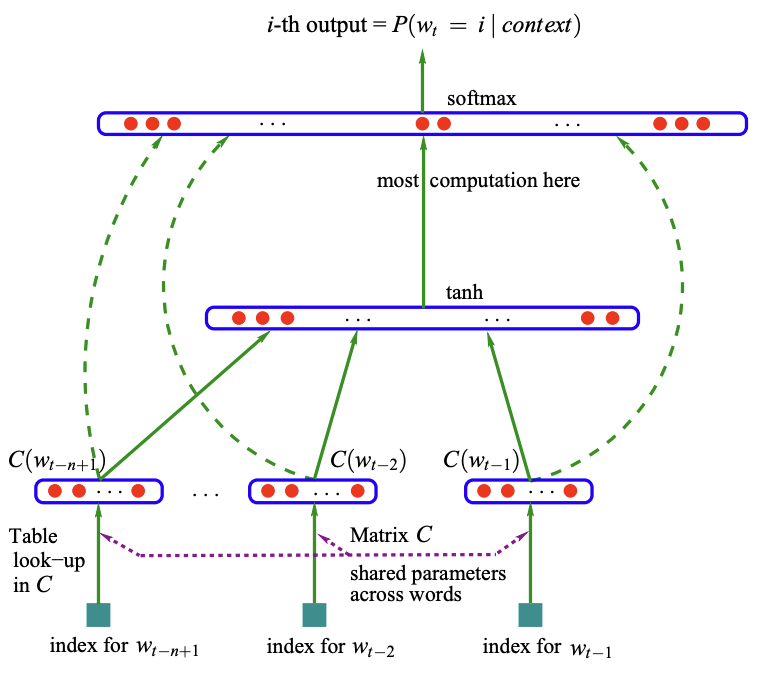

In [19]:
# Let's create the second layer (lookup for embeddings)
C = torch.randn((27, 2))
C

tensor([[ 0.4035, -1.7884],
        [ 0.3905, -1.9207],
        [ 0.1122, -1.0837],
        [-0.9693, -1.1894],
        [-1.7298,  0.2833],
        [ 0.8384,  0.5883],
        [ 0.5470,  0.1428],
        [ 0.4391, -0.5482],
        [ 0.9918,  0.7372],
        [ 0.1896, -0.1542],
        [-0.1982, -0.5326],
        [ 0.7639, -0.0487],
        [-0.5338,  0.2871],
        [-0.0686, -1.4324],
        [-0.1023, -0.0847],
        [ 0.4910,  1.6397],
        [ 1.0581,  0.5808],
        [ 0.4819,  0.6202],
        [ 1.2838,  0.7581],
        [ 1.0834, -1.2909],
        [ 0.1551, -1.2097],
        [ 0.4183, -0.3634],
        [-0.3963,  0.5907],
        [ 0.4119,  0.6049],
        [ 0.4084,  1.8310],
        [-1.2339, -1.0990],
        [ 1.1242,  0.1140]])

In [20]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [21]:
# weights and biases
w1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [25]:
# concatenate the three characters of the context from embeddings
# emb @ w1 + b1 won't work, since these are not the same size
# this code is not generalizable, because we can't increase the context size (we'll need to change the code)
sqaushed = torch.concat([emb[:, 0, :], emb[:, 1, :],emb[:, 2, :]] ,dim=1)
sqaushed.shape

torch.Size([32, 6])

In [29]:
# a more generic way is to use unbind
squashed = torch.cat(torch.unbind(emb, 1), 1)
sqaushed.shape

torch.Size([32, 6])

In [32]:
# the best way to do this is with torch.view() function
a = torch.arange(18)
print(a)
print(a.view(2, 9))
print(a.view(9, 2))
print(a.view(3, 3, 2))

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])
tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])
tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17]])
tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])


In [34]:
h = emb.view(-1,6) @ w1 + b1
h.shape

torch.Size([32, 100])

In [38]:
h = torch.tanh(emb.view(-1,6) @ w1 + b1)
h.shape

torch.Size([32, 100])

In [47]:
# last layer
w2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [48]:
logits = h @ w2 + b2
logits.shape

torch.Size([32, 27])

In [49]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([32, 27])